In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = "/content/drive/MyDrive/Scocial Media Data Mining/Dataset/UIT-VSMEC"
%cd /content/drive/MyDrive/Scocial Media Data Mining/Dataset/UIT-VSMEC
!ls

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/Dataset/UIT-VSMEC
 test_nor_811.xls    train_nor_811.xls	 'valid_nor_811 (1).xlsx'
 test_nor_811.xlsx   train_nor_811.xlsx   valid_nor_811.xlsx


# 1. Import thư viện

In [3]:
!pip install transformers

     |████████████████████████████████| 2.5MB 2.9MB/s 
     |████████████████████████████████| 3.3MB 22.6MB/s 
     |████████████████████████████████| 901kB 38.3MB/s 


In [4]:
import torch
import pandas as pd
import numpy as np

# Thu vien transformer cho Classification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification, XLMRobertaForSequenceClassification, RobertaForSequenceClassification

# Xu ly label
from sklearn.preprocessing import LabelEncoder

# Metric danh gia 
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Ve do thi
import seaborn as sn
import matplotlib.pyplot as plt

# 2. Load data

In [5]:
train = pd.read_excel(path + "/train_nor_811.xlsx", index_col=False)
dev = pd.read_excel(path + "/valid_nor_811.xlsx", index_col=False)
test = pd.read_excel(path + "/test_nor_811.xlsx", index_col=False)

X_train = train['Sentence']
y_train = train['Emotion'].values

X_dev = dev['Sentence']
y_dev = dev['Emotion'].values

X_test = test['Sentence']
y_test = test['Emotion'].values

In [6]:
train['Emotion'].unique() # Có 7 phân lớp cho cảm xúc

array(['Other', 'Disgust', 'Enjoyment', 'Anger', 'Surprise', 'Sadness',
       'Fear'], dtype=object)

In [7]:
len(train['Emotion'].unique())

7

In [8]:
# Create object "le" to encoding label 
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [9]:
pd.Series(y_train).unique()

array(['Other', 'Disgust', 'Enjoyment', 'Anger', 'Surprise', 'Sadness',
       'Fear'], dtype=object)

In [10]:
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 3. XLM-R

In [11]:
# Khai bao pre-trained
# Mặc định model pretrain được lấy từ trang: https://huggingface.co/models
# Ngoài ra có thể truyền vào path của model ở trang web khác
xlm_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels = len(train['Emotion'].unique()))
xlm_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [ ]:
train_encodings = xlm_tokenizer(X_train.to_list(), truncation=True, padding=True, max_length=40)
dev_encodings = xlm_tokenizer(X_dev.to_list(), truncation=True, padding=True, max_length=40)
test_encodings = xlm_tokenizer(X_test.to_list(), truncation=True, padding=True, max_length=40)

y_train_encoding = le.transform(y_train)
y_dev_encoding = le.transform(y_dev)
y_test_encoding = le.transform(y_test)

In [12]:
import pickle

# saving
with open('/content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Thien_XLM/UIT-VSMEC/le.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(len(X_train)) # Kích thước ban đầu
print(len(X_train.loc[X_train.str.count(" ") > 40])) #Số lượng câu có số từ lớn hơn 40 (xấp xỉ)
X_train.loc[X_train.str.count(" ") > 40]

5548
121


8       ko phải con mình , mà xem còn thấy đau như vậy...
26      cá nhân mình nghĩ nó dừng hay đỗ đúng sai thì ...
62      hồi nhỏ bà mày có cho một con ngỗng mình tự ta...
95      có những con người luôn phải chịu đắng cay , c...
103     thằng nào nói câu : thế thì đừng làm nghề này ...
                              ...                        
5334    địt mẹ , mình làm khách sạn , lúc vào check ph...
5340    tao đã từng bị , gào thét không 1 ai quan tâm ...
5360    không cho giáo viên cái quyền gì thì lấy gì mà...
5407    mẹ kể hồi nhỏ nuôi con ngỗng thay chó canh nhà...
5439    mấy con này phải có ngày mấy thằng xe lớn nó t...
Name: Sentence, Length: 121, dtype: object

In [ ]:
print(X_train[8])
train_encodings

ko phải con mình , mà xem còn thấy đau như vậy huống gì người trong cuộc . thật là phẫn nộ mà . cơ quan chức năng làm việc quá chậm trễ , đến giờ mà vẫn chưa tìm ra người chịu trách nhiệm . 😠😠😠😠😠😠


{'input_ids': [[0, 681, 3087, 21928, 9031, 52044, 10587, 580, 4062, 1116, 125576, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 681, 25333, 16774, 158, 209765, 6, 5, 1893, 2455, 84854, 14, 158, 2455, 86894, 673, 2232, 13868, 6, 244728, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 459, 2546, 2467, 6, 5, 7813, 92821, 62077, 4062, 2054, 1917, 12186, 2546, 3811, 2546, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 75, 38068, 238, 4062, 858, 1617, 1893, 9645, 8123, 524, 1451, 1641, 24399, 1617, 32559, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 17356, 9230, 524, 1202, 550, 158, 580, 17363, 31789, 2467, 31789, 1917, 1096, 140687, 6, 5, 23823, 449, 158, 6526, 6, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 141752, 19176, 6284, 86894, 13363, 37435, 1116, 876, 103892, 5376, 208378, 3061, 19176, 6, 5, 2455, 86894, 2059, 16922, 5376, 1885, 77815, 86894, 22

In [ ]:
train_dataset = BuildDataset(train_encodings, y_train_encoding)
dev_dataset = BuildDataset(dev_encodings, y_dev_encoding)
test_dataset = BuildDataset(test_encodings, y_test_encoding)

In [ ]:
%cd /content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Thien_XLM/UIT-VSMEC/results_1
!ls

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/SourceCode/Thien_XLM/UIT-VSMEC/results_1


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=100,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

xlm_trainer = Trainer(
    model=xlm_model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

In [ ]:
# huan luyen mo hinh

xlm_trainer.train()

Step,Training Loss
500,1.509000
1000,0.857500
1500,0.453600
2000,0.222400
2500,0.152900
3000,0.127500
3500,0.101700
4000,0.088400
4500,0.071000
5000,0.053500


TrainOutput(global_step=17400, training_loss=0.11662836636962562, metrics={'train_runtime': 7409.3923, 'train_samples_per_second': 2.348, 'total_flos': 850162717185600.0, 'epoch': 100.0, 'init_mem_cpu_alloc_delta': 1942376448, 'init_mem_gpu_alloc_delta': 1112270848, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -1654411264, 'train_mem_gpu_alloc_delta': 3354394112, 'train_mem_cpu_peaked_delta': 2437783552, 'train_mem_gpu_peaked_delta': 925129728})

In [ ]:
# assert False

In [ ]:
 # Du doan 
y_pred_classify = xlm_trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)

#Code đánh giá mô hình chi tiết trên 4 độ đo

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# Danh gia mo hinh
y_true = y_test_encoding
y_pred_classify = xlm_trainer.predict(test_dataset)
y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
cf = confusion_matrix(y_true, y_pred, labels= pd.Series(y_true).unique())

print(cf)
print("accuracy: " + str(accuracy_score(y_true, y_pred)))
print("F1 - macro: " + str(f1_score(y_true, y_pred, average='macro')))
target_names = pd.Series(y_test).astype(str).unique()
print('Classification report in Training set')
print(classification_report(y_true, y_pred, labels=pd.Series(y_true).unique(), target_names=target_names))

[[ 80   0   7   4   3   8  14]
 [  2  16   3   0   1   8   7]
 [  9   1  79   4  16   9  14]
 [  4   1   5  30   1   3   2]
 [  2   0   9   1  27   0   1]
 [  7   5  14   5   8  73  17]
 [ 14   2  12   2   1  17 145]]
accuracy: 0.6493506493506493
F1 - macro: 0.6204478925826267
Classification report in Training set
              precision    recall  f1-score   support

     Sadness       0.68      0.69      0.68       116
    Surprise       0.64      0.43      0.52        37
     Disgust       0.61      0.60      0.61       132
        Fear       0.65      0.65      0.65        46
       Anger       0.47      0.68      0.56        40
       Other       0.62      0.57      0.59       129
   Enjoyment       0.72      0.75      0.74       193

    accuracy                           0.65       693
   macro avg       0.63      0.62      0.62       693
weighted avg       0.65      0.65      0.65       693



In [ ]:
print(pd.Series(y_test).unique())
print(pd.Series(y_true).unique())

['Sadness' 'Surprise' 'Disgust' 'Fear' 'Anger' 'Other' 'Enjoyment']
[5 6 1 3 0 4 2]


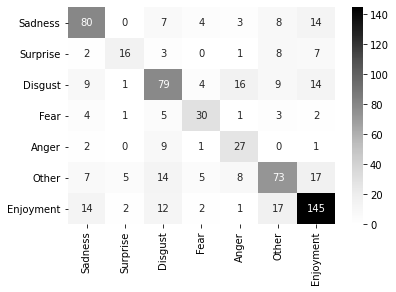

In [ ]:
# Ve ma tran nham lan
df_cm = pd.DataFrame(cf, index = pd.Series(y_test).unique(),
                  columns = pd.Series(y_test).unique())

sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 10})